In [26]:
import json
import networkx as nx
from itertools import combinations

with open("festival_network_attributes.json", "r", encoding="utf-8") as f:
    B = nx.node_link_graph(json.load(f), edges="links")

festival_year_nodes = [n for n, d in B.nodes(data=True) if d.get("bipartite") == "festival_year"]
if not festival_year_nodes:
    raise ValueError("No nodes found with bipartite=='festival_year'")

nbrs = {u: set(B.neighbors(u)) for u in festival_year_nodes}

G = nx.Graph()
for u in festival_year_nodes:
    G.add_node(u, **B.nodes[u])

for u, v in combinations(festival_year_nodes, 2):
    inter = len(nbrs[u] & nbrs[v])
    if inter == 0:
        continue
    union = len(nbrs[u] | nbrs[v])
    G.add_edge(u, v, weight=inter / union)

communities = nx.algorithms.community.louvain_communities(G, weight="weight", resolution=1.0, seed=0)
communities = sorted(communities, key=len, reverse=True)
node_to_comm = {node: cid for cid, comm in enumerate(communities) for node in comm}

print("Nodes:", G.number_of_nodes(), "Edges:", G.number_of_edges(), "Communities:", len(communities))


Nodes: 319 Edges: 15829 Communities: 13


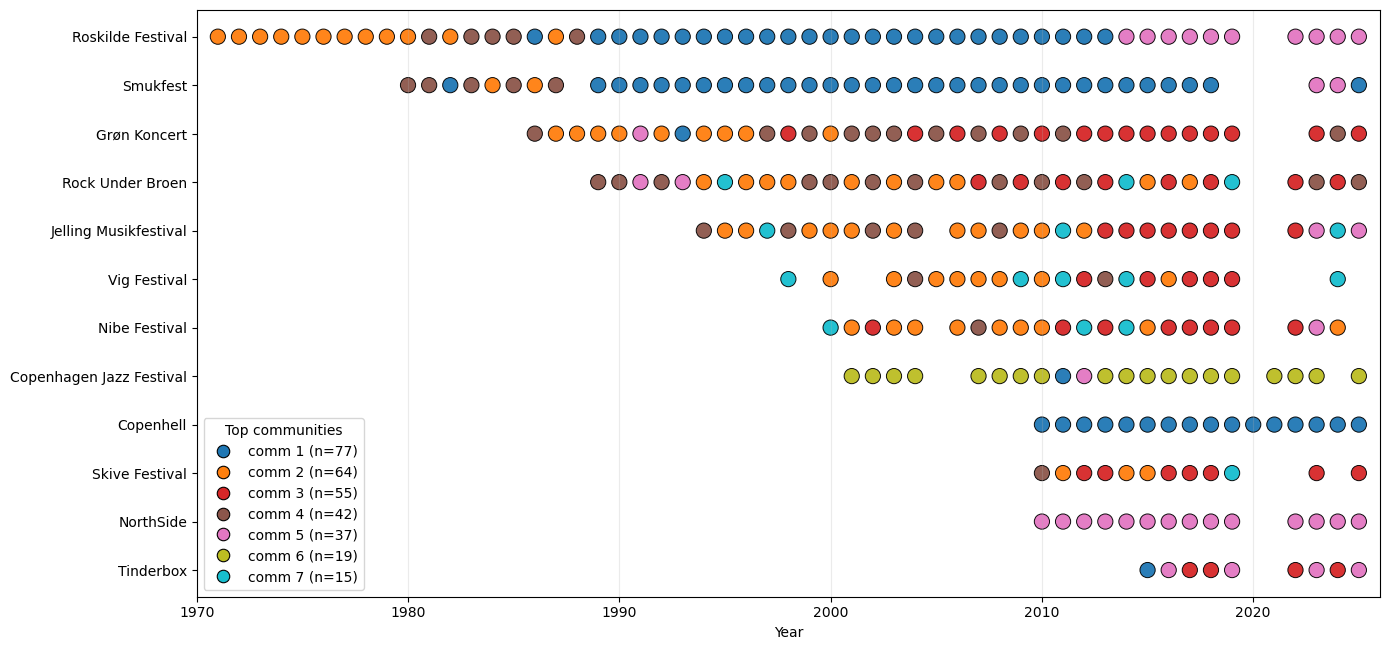

In [ ]:
#Creating community plot
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from collections import defaultdict, Counter

FESTIVAL_LABELS = {
    "roskilde": "Roskilde Festival",
    "smukfest": "Smukfest",
    "copenhell": "Copenhell",
    "copenhagen": "Copenhagen Jazz Festival",
    "groen": "Grøn Koncert",
    "jelling": "Jelling Musikfestival",
    "nibe": "Nibe Festival",
    "rock": "Rock Under Broen",
    "skive": "Skive Festival",
    "vig": "Vig Festival",
    "northside": "NorthSide",
    "tinderbox": "Tinderbox",
}

def plot_festival_timeline_top_communities(B, node_to_comm, top_k=7, festival_labels=None):
    festival_labels = festival_labels or {}

    comm_sizes = Counter()
    valid = []
    for node, cid in node_to_comm.items():
        if node not in B:
            continue
        d = B.nodes[node]
        if d.get("bipartite") != "festival_year":
            continue
        fest = d.get("festival")
        year = d.get("year")
        if fest is None or year is None:
            continue
        try:
            int(year)
        except:
            continue
        valid.append(node)
        comm_sizes[cid] += 1

    non_singletons = [(cid, sz) for cid, sz in comm_sizes.items() if sz > 1]
    non_singletons.sort(key=lambda x: x[1], reverse=True)
    top_comms = [cid for cid, _ in non_singletons[:top_k]]
    top_set = set(top_comms)

    by_fest = defaultdict(list)
    for node in valid:
        cid = node_to_comm[node]
        if cid not in top_set:
            continue
        d = B.nodes[node]
        by_fest[d["festival"]].append((int(d["year"]), cid))

    if not by_fest:
        print("Nothing to plot: no nodes belong to the selected communities.")
        return

    for fest in by_fest:
        by_fest[fest].sort()

    # Sort by first year, and reverse order
    festivals_raw = sorted(by_fest.keys(), key=lambda f: by_fest[f][0][0])[::-1]
    festivals_display = [festival_labels.get(f, f) for f in festivals_raw]

    cid_to_idx = {cid: i for i, cid in enumerate(top_comms)}
    cmap = plt.get_cmap("tab10" if len(top_comms) <= 10 else "tab20", len(top_comms))

    xs, ys, cols = [], [], []
    for row, fest in enumerate(festivals_raw):
        for year, cid in by_fest[fest]:
            xs.append(year)
            ys.append(row)
            cols.append(cmap(cid_to_idx[cid]))

    fig_h = max(5, 0.55 * len(festivals_raw))
    plt.figure(figsize=(14, fig_h))
    plt.scatter(xs, ys, c=cols, s=120, alpha=0.95, edgecolors="black", linewidths=0.7)

    plt.yticks(range(len(festivals_raw)), festivals_display)
    plt.xlabel("Year")
    plt.grid(axis="x", alpha=0.25)
    plt.xlim(min(xs) - 1, max(xs) + 1)

    handles = []
    for cid in top_comms:
        i = cid_to_idx[cid]
        handles.append(
            Line2D([0], [0], marker="o", linestyle="",
                   markersize=9, markerfacecolor=cmap(i),
                   markeredgecolor="black", markeredgewidth=0.8,
                   label=f"comm {cid+1} (n={comm_sizes[cid]})")
        )

    plt.legend(handles=handles, title="Top communities", loc="lower left", frameon=True)
    plt.tight_layout()
    plt.show()

plot_festival_timeline_top_communities(B, node_to_comm, top_k=7, festival_labels=FESTIVAL_LABELS)


In [ ]:
import json
import networkx as nx
import numpy as np
from collections import defaultdict, Counter

with open("festival_network_attributes.json", "r", encoding="utf-8") as f:
    data = json.load(f)

B = nx.node_link_graph(data, edges="links")

# Communities list for modularity
comm_to_nodes = defaultdict(set)
for node, cid in node_to_comm.items():
    comm_to_nodes[cid].add(node)
communities_list = list(comm_to_nodes.values())

# Overall modularity
mod = nx.algorithms.community.quality.modularity(G, communities_list, weight="weight")
print("Overall modularity (partition on projected graph):", round(mod, 4))

def comm_internal_weight(G, S):
    total = 0.0
    for u in S:
        for v, attrs in G[u].items():
            if v in S and u < v:
                total += attrs.get("weight", 1.0)
    return total

def comm_cut_weight(G, S):
    total = 0.0
    for u in S:
        for v, attrs in G[u].items():
            if v not in S:
                total += attrs.get("weight", 1.0)
    return total

def weighted_degree(G, u):
    return sum(attrs.get("weight", 1.0) for _, attrs in G[u].items())

def comm_volume(G, S):
    return sum(weighted_degree(G, u) for u in S)

def to_percent_dict(d):
    total = sum(d.values())
    if total <= 0:
        return {}
    return {k: 100.0 * v / total for k, v in d.items()}

comm_genres = defaultdict(lambda: defaultdict(float)) 
comm_pop = defaultdict(list)
comm_years = defaultdict(list)
comm_fest = defaultdict(Counter)

missing = 0

for fy_node, cid in node_to_comm.items():
    if fy_node not in B:
        missing += 1
        continue

    d = B.nodes[fy_node]
    y = d.get("year")
    if y is not None:
        try:
            comm_years[cid].append(int(y))
        except:
            pass

    f = d.get("festival")
    if f is not None:
        comm_fest[cid][f] += 1

    for a in B.neighbors(fy_node):
        if B.nodes[a].get("bipartite") != "artist":
            continue

        genres = B.nodes[a].get("genres") or []
        # Fractional counting: total contribution per artist = 1 split across genres
        if genres:
            w = 1.0 / len(genres)
            for g in genres:
                if g:  # keep original names, just skip empty
                    comm_genres[cid][g] += w

        pop = B.nodes[a].get("popularity")
        if isinstance(pop, (int, float)):
            comm_pop[cid].append(pop)

print("Skipped festival-year nodes not in B:", missing)

# Print descriptive blocks
all_cids = sorted(comm_to_nodes.keys(), key=lambda c: len(comm_to_nodes[c]), reverse=True)

for cid in all_cids:
    S = comm_to_nodes[cid]

    n_nodes = len(S)
    w_int = comm_internal_weight(G, S)
    w_cut = comm_cut_weight(G, S)
    volS = comm_volume(G, S)
    volNotS = comm_volume(G, set(G.nodes()) - set(S))
    denom = min(volS, volNotS) if min(volS, volNotS) > 0 else None
    conductance = (w_cut / denom) if denom else None

    years = comm_years.get(cid, [])
    year_span = (min(years), max(years)) if years else None
    top_fests = comm_fest[cid].most_common(5)

    pops = comm_pop.get(cid, [])
    mean_pop = float(np.mean(pops)) if pops else None
    med_pop = float(np.median(pops)) if pops else None

    # ORIGINAL genre names, fractional, normalized to percentages
    raw_pct = to_percent_dict(comm_genres[cid])
    top_raw = sorted(raw_pct.items(), key=lambda kv: kv[1], reverse=True)[:12]

    print(f"\n=== Community {cid} ===")
    print(f"festival-year nodes: {n_nodes}")
    print(f"year span: {year_span}" if year_span else "year span: n/a")
    print("top festivals:", top_fests)
    print(f"internal edge weight: {w_int:.3f} | cut weight: {w_cut:.3f}")
    print("conductance (lower=more separated):", round(conductance, 4) if conductance is not None else "n/a")
    print("artist popularity mean/median:", (round(mean_pop, 2), round(med_pop, 2)) if pops else "n/a")
    print("original genre % (fractional, top):", [(g, round(p, 2)) for g, p in top_raw])


Overall modularity (partition on projected graph): 0.4397
Skipped festival-year nodes not in B: 15

=== Community 7 ===
festival-year nodes: 110
year span: (1986, 2025)
top festivals: [('roskilde', 35), ('smukfest', 34), ('copenhagen', 21), ('copenhell', 16), ('jelling', 2)]
internal edge weight: 49.381 | cut weight: 76.105
conductance (lower=more separated): 0.4352
artist popularity mean/median: (38.47, 40.0)
original genre % (fractional, top): [('dansk pop', 15.88), ('dansktop', 9.34), ('dansk rap', 4.95), ('metal', 1.28), ('swedish pop', 1.26), ('rock', 1.0), ('alternative rock', 0.97), ('christmas', 0.9), ('death metal', 0.89), ('indie rock', 0.83), ("children's music", 0.76), ('norwegian pop', 0.73)]

=== Community 1 ===
festival-year nodes: 96
year span: (1985, 2025)
top festivals: [('rock', 25), ('jelling', 21), ('vig', 17), ('groen', 12), ('skive', 11)]
internal edge weight: 211.240 | cut weight: 205.486
conductance (lower=more separated): 0.3272
artist popularity mean/median: 

Projected graph: 319 nodes, 15829 edges
Backbone: 301 nodes, 1148 edges


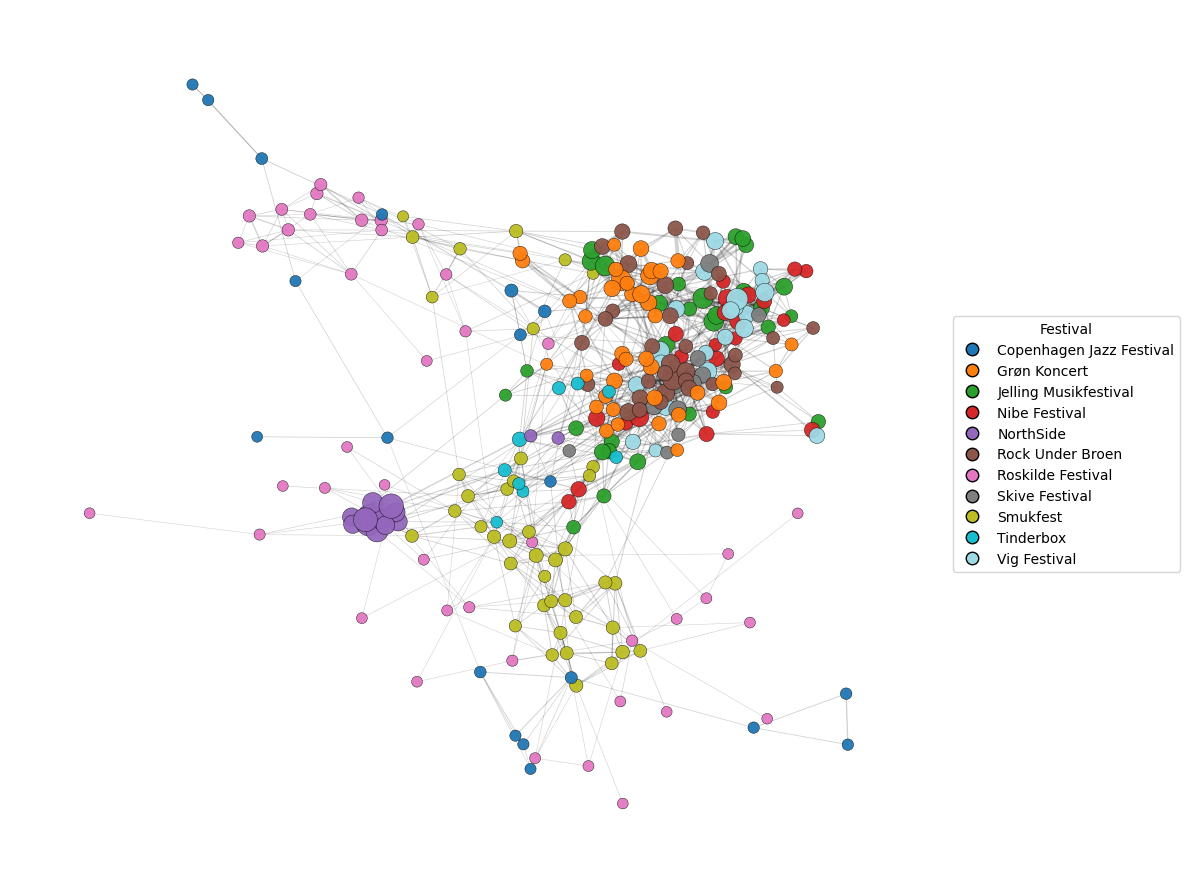

In [30]:
import json
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
from collections import defaultdict
from matplotlib.lines import Line2D

# -------------------------
# CONTROL FESTIVAL NAMES HERE (legend labels)
# keys must match node attribute: d["festival"]
# -------------------------
FESTIVAL_LABELS = {
    "roskilde": "Roskilde Festival",
    "smukfest": "Smukfest",
    "copenhell": "Copenhell",
    "copenhagen": "Copenhagen Jazz Festival",
    "groen": "Grøn Koncert",
    "jelling": "Jelling Musikfestival",
    "nibe": "Nibe Festival",
    "rock": "Rock Under Broen",
    "skive": "Skive Festival",
    "vig": "Vig Festival",
    "northside": "NorthSide",
    "tinderbox": "Tinderbox",
}

# -------------------------
# 1) Load bipartite graph
# -------------------------
with open("festival_network_attributes.json", "r", encoding="utf-8") as f:
    B = nx.node_link_graph(json.load(f), edges="links")

festival_nodes = [n for n, d in B.nodes(data=True) if d.get("bipartite") == "festival_year"]

# -------------------------
# 2) Project with Jaccard weights
# -------------------------
nbrs = {u: set(B.neighbors(u)) for u in festival_nodes}

G = nx.Graph()
for u in festival_nodes:
    G.add_node(u, **B.nodes[u])

for u, v in combinations(festival_nodes, 2):
    inter = len(nbrs[u] & nbrs[v])
    if inter == 0:
        continue
    union = len(nbrs[u] | nbrs[v])
    w = inter / union
    G.add_edge(u, v, weight=w)

print("Projected graph:", G.number_of_nodes(), "nodes,", G.number_of_edges(), "edges")

# -------------------------
# 3) Backbone: kNN edges per node
# -------------------------
def knn_backbone(G, k=6, weight="weight", union=True, min_weight=0.0):
    keep = set()
    for u in G.nodes():
        edges = []
        for v, d in G[u].items():
            w = d.get(weight, 1.0)
            if w >= min_weight:
                edges.append((w, u, v))
        edges.sort(reverse=True)
        for w, a, b in edges[:k]:
            keep.add((a, b) if a < b else (b, a))

    H = nx.Graph()
    H.add_nodes_from(G.nodes(data=True))

    if union:
        for a, b in keep:
            if G.has_edge(a, b):
                H.add_edge(a, b, **G[a][b])
    else:
        chosen = defaultdict(set)
        for a, b in keep:
            chosen[a].add(b)
            chosen[b].add(a)
        for a, b in keep:
            if (b in chosen[a]) and (a in chosen[b]) and G.has_edge(a, b):
                H.add_edge(a, b, **G[a][b])

    isolates = [n for n in H.nodes() if H.degree(n) == 0]
    H.remove_nodes_from(isolates)
    return H

H = knn_backbone(G, k=6, min_weight=0.03, union=True)
print("Backbone:", H.number_of_nodes(), "nodes,", H.number_of_edges(), "edges")

# largest connected component (optional; makes one clean figure)
if H.number_of_nodes() > 0:
    cc = max(nx.connected_components(H), key=len)
    H = H.subgraph(cc).copy()

# -------------------------
# 4) Plot with legend (no labels on nodes)
# -------------------------
def plot_projected_backbone_with_legend(H, seed=42):
    pos = nx.spring_layout(H, seed=seed, weight="weight")

    festivals = sorted({H.nodes[n].get("festival", "unknown") for n in H.nodes()})
    cmap = plt.get_cmap("tab20", max(1, len(festivals)))
    fest_color = {f: cmap(i) for i, f in enumerate(festivals)}

    node_colors = [fest_color.get(H.nodes[n].get("festival", "unknown")) for n in H.nodes()]

    # node size = weighted degree (strength)
    strength = {n: sum(H[n][nbr].get("weight", 1.0) for nbr in H.neighbors(n)) for n in H.nodes()}
    svals = list(strength.values()) or [1.0]
    smin, smax = min(svals), max(svals)
    def scale(x):
        if smax == smin:
            return 90
        return 60 + 260 * (x - smin) / (smax - smin)
    node_sizes = [scale(strength[n]) for n in H.nodes()]

    # edges: width by weight
    wvals = [d.get("weight", 1.0) for _, _, d in H.edges(data=True)] or [1.0]
    wmin, wmax = min(wvals), max(wvals)
    def escale(w):
        if wmax == wmin:
            return 1.0
        return 0.4 + 4.0 * (w - wmin) / (wmax - wmin)
    edge_widths = [escale(d.get("weight", 1.0)) for _, _, d in H.edges(data=True)]

    plt.figure(figsize=(12, 9))
    nx.draw_networkx_edges(H, pos, alpha=0.18, width=edge_widths)
    nx.draw_networkx_nodes(
        H, pos,
        node_color=node_colors,
        node_size=node_sizes,
        edgecolors="black",
        linewidths=0.3,
        alpha=0.95
    )

    # Legend handles (festival -> color)
    handles = []
    for f in festivals:
        label = FESTIVAL_LABELS.get(f, f)  # <-- control names via FESTIVAL_LABELS
        handles.append(Line2D(
            [0], [0], marker='o', linestyle='',
            markerfacecolor=fest_color[f], markeredgecolor='black',
            markersize=9, label=label
        ))

    plt.legend(
        handles=handles,
        title="Festival",
        loc="center left",
        bbox_to_anchor=(1.02, 0.5),
        frameon=True
    )

    plt.axis("off")
    plt.tight_layout()
    plt.show()

plot_projected_backbone_with_legend(H, seed=42)
